In [30]:
import copy
import sys
import time

import matplotlib.pyplot as plt
import numpy as np

# Low Level Arrays

In [2]:
l = [1, 2, 3]
l2 = l[:]       # Shallow copy
l == l2, l, l2

(True, [1, 2, 3], [1, 2, 3])

In [3]:
l2[0] = 10
l == l2, l, l2

(False, [1, 2, 3], [10, 2, 3])

In [4]:
l = [[1], 2, 3]
l2 = l[:] 
l == l2, l, l2

(True, [[1], 2, 3], [[1], 2, 3])

In [5]:
l2[0][0] = 10
l == l2, l, l2

(True, [[10], 2, 3], [[10], 2, 3])

Lists and tuples are referential arrays; therefore, even when we make a copy of the original list/tuple, we are basically copying the references of their elements. As a result:
- If the element is immutable, changing the original list/tuple won't change the copied list and vice versa.
- If the element is mutable, changing the original list/tuple will change the copied list and vice versa.

Therefore, use `deepcopy` to get just the elements.

In [6]:
l = [[1], 2, 3]
l2 = copy.deepcopy(l)
l == l2, l, l2

(True, [[1], 2, 3], [[1], 2, 3])

In [7]:
l2[0].append(10)
l == l2, l, l2

(False, [[1], 2, 3], [[1, 10], 2, 3])

Since lists and tuples are referential arrays, they store the addresses of all elements (each address is 64-bit). This means the overall memory usage is len(list) * 64-bit + len(list) * data-type-size. Also, the data are not necessarily stored in contiguous memory cells. Therefore, moving the list around is not that expensive since it only holds the addresses and not the actual data.

`str` class stores the characters in compact array (all elements must have the same data type). This means stores the bits of the characters in contiguous memory cells and doesn't store addresses. This will save memory usage but also means when you're moving the string around, you are moving all the data and not the addresses as is the case with referential arrays.

Since it is immutable data structure:
- We can't change the elements of the string unless we create new string.
- Can't extend or add elements to it, we need to create new object.

In [8]:
string = 'imad'
string

'imad'

In [9]:
string[0] = 'd'

TypeError: 'str' object does not support item assignment

In [10]:
sys.getsizeof(string), sys.getsizeof('')

(53, 49)

# Dynamic Arrays

The array that holds the addresses of referential data structures (list/tuple) is contiguous but the actual elements are not. Therefore, since lists are mutable (tuples are not), we can't keep adding elements to the list since memory cells next to the last element may be used by other data structure. This means we may need to copy the array somewhere else in memory to increase its size. Immutable data structures don't have this issue since number of elements are fixed and if we want to add new elements, we create new object.

In [11]:
l = []
for _ in range(30):
    print(f'Length : {len(l):2d} ; Size in bytes : {sys.getsizeof(l):3d}')
    l.append(None)

Length :  0 ; Size in bytes :  64
Length :  1 ; Size in bytes :  96
Length :  2 ; Size in bytes :  96
Length :  3 ; Size in bytes :  96
Length :  4 ; Size in bytes :  96
Length :  5 ; Size in bytes : 128
Length :  6 ; Size in bytes : 128
Length :  7 ; Size in bytes : 128
Length :  8 ; Size in bytes : 128
Length :  9 ; Size in bytes : 192
Length : 10 ; Size in bytes : 192
Length : 11 ; Size in bytes : 192
Length : 12 ; Size in bytes : 192
Length : 13 ; Size in bytes : 192
Length : 14 ; Size in bytes : 192
Length : 15 ; Size in bytes : 192
Length : 16 ; Size in bytes : 192
Length : 17 ; Size in bytes : 264
Length : 18 ; Size in bytes : 264
Length : 19 ; Size in bytes : 264
Length : 20 ; Size in bytes : 264
Length : 21 ; Size in bytes : 264
Length : 22 ; Size in bytes : 264
Length : 23 ; Size in bytes : 264
Length : 24 ; Size in bytes : 264
Length : 25 ; Size in bytes : 264
Length : 26 ; Size in bytes : 344
Length : 27 ; Size in bytes : 344
Length : 28 ; Size in bytes : 344
Length : 29 ; 

Looks like list overhead memory usage is 64 bytes (empty list). List increases its capacity by 4. Note that the size is only for the addresses and not the referenced objects.

In [12]:
l = [1, 2, 3]
l1 = ['name', 'age', 'job']
sys.getsizeof(l), sys.getsizeof(l1)

(88, 88)

## Dynamic array implementation

In [13]:
import ctypes


class DynamicArray:
    '''A dynamic array class similar to Python list.'''

    def __init__(self):
        '''Create an empty array.'''
        self._n = 0
        self._capacity = 1
        self._A = self._make_array(self._capacity)

    def __len__(self):
        '''Returns the number of elements stored in the array.'''
        return len(self._A)

    def __getitem__(self, i):
        '''Returns the element at index i.'''
        if not 0 <= i < self._n:
            raise IndexError('invalid index')
        return self._A[i]

    def append(self, obj):
        '''Add object to the end of the array.'''
        if self._n == self._capacity:
            self._resize(self._capacity * 2)
        self._A[self._n] = obj
        self._n += 1

    def __contains__(self, val):
        '''Returns True if val in the list, False otherwise.'''
        for i in range(self._n):
            if val == self._A[i]:
                return True
        return False

    def index(self, val):
        '''Returns the index of val, or raise ValueError.'''
        for i in range(self._n):
            if val == self._A[i]:
                return i
        raise ValueError('value not in list.')

    def count(self, val):
        '''Return number of occurrences of value.'''
        res = 0
        for i in range(self._n):
            if val == self._A[i]:
                res += 1
        return res

    def insert(self, k, val):
        '''Insert val at index k, shifting subsequent values rightward.'''
        if self._n == self._capacity:
            # Double the size of the array since it is full
            self._resize(self._capacity * 2)
        for i in range(self._n, k, -1):
            self._A[i] = self._A[i - 1]
        self._A[k] = val
        self._n += 1

    def remove(self, val):
        '''Remove first occurance of val, shifting subsequent values leftward.'''
        for i in range(self._n):
            if val == self._A[i]:
                for j in range(i, self._n - 1):
                    self._A[j] = self._A[i + 1]
                self._A[self._n - 1] = None         # Avoid loitering
                self._n -= 1
                if self._n > 0 and self._n == self._capacity / 4:
                    # Half the array
                    self._resize(self._capacity * 0.5)
                return
        raise ValueError('val not found')

    def reverse(self):
        '''Reverse list in place.'''
        if self._n <= 1:
            return
        for i in range(self._n // 2):
            self._A[i], self._A[self._n - i - 1] = (self._A[self._n - i - 1],
                                                    self._A[i])
    def _resize(self, c):
        '''Resize internal array to new capacity c.'''
        B = self._make_array(c)
        for i in range(self._n):
            B[i] = self._A[i]
        self._A = B
        self._capacity = c

    def _make_array(self, c):
        '''Return an empty array with capacity c.'''
        return (c * ctypes.py_object)()


In [14]:
a = DynamicArray()
a

In [15]:
len(a)

1

In [16]:
a.append(100)
a[0]

100

In [17]:
a.append(1000)
a._capacity

2

In [18]:
a.append(1)
a._capacity

4

In [19]:
100 in a, 0 in a

(True, False)

In [20]:
a.count(100)

1

In [21]:
for val in a:
    print(val)

100
1000
1


In [22]:
a.insert(0, 0)

In [23]:
len(a)

4

In [24]:
for val in a:
    print(val)

0
100
1000
1


In [25]:
a.remove(1000)

In [26]:
for val in a:
    print(val)

0
100
1


In [27]:
a.reverse()

In [28]:
for val in a:
    print(val)

1
100
0


## Python List class

In [29]:
l_length = [10 ** i for i in range(2, 9)]
append_avg = []
for n in l_length:
    l = []
    start = time.time()
    for _ in range(n):
        l.append(None)
    end = time.time()
    avg_time = (end - start) / n
    append_avg.append(avg_time)

In [31]:
np.log10(append_avg)

array([-6.7965851 , -6.8862634 , -6.87587007, -6.88679763, -7.01933795,
       -7.06247461, -7.06617562])

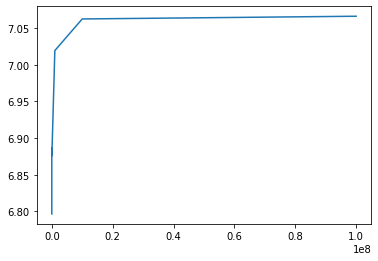

In [32]:
plt.plot(l_length, - np.log10(append_avg))
# plt.ylim([1e-9, 1e-5])

As the above data shows, append operation is independent of the size of the list.

## Python String class

- Methods that test for boolean conditions are O(n) such as `islower(s)`. Note that it terminates once the condition is violated (for example if the first letter is capitalized).
- Typical string matching such as find/replace takes O(mn) because it considers n - m + 1 starting positions and O(m) at each starting position.
- Concatenating two strings takes O(n^2) since strings are immutable. Newer version of Python may change the string itself if the ref_count is not reference by any other object than the current object itself.
- we can use list comprehension to store all parts of string and then use `''.join(s)` to concatenate the string.
    - `''.join([char for char in documnet if char.isalpha()])`
    - `''.join((char for char in documnet if char.isalpha()))`. This is faster than list comprehension because we can avoid the temporary list (since it is generator comprehension).

In [33]:
name = 'dabbura'
sys.getrefcount(name)

3

In [34]:
id(name)

5624028888

In [35]:
name += 'imad'
id(name)

4430805680

# Applications

In [36]:
class GameEntry:
    '''Represents one entry of a list of high scores.'''
    
    def __init__(self, name, score):
        self._name = name
        self._score = score
    
    def get_name(self):
        return self._name
    
    def get_score(self):
        return self._score
    
    def __str__(self):
        return f'{self._name}, {self._score}'

In [37]:
game = GameEntry('imad', 100)
print(game)

imad, 100


In [38]:
class Scoreboard:
    '''Fixed-length sequence of high scores in nondecreasing order.'''
    
    def __init__(self, capacity):
        self._board = [None] * capacity
        self._n = 0
    
    def __getitem__(self, i):
        '''Return entry at index i.'''
        return self._board[i]
    
    def __str__(self):
        return f'\n'.join((entry for entry in self._board))
    
    def add(self, entry):
        '''Consider adding entry to high scores (preserving order).'''
        score = entry.get_score()
        
        add = self._n < len(self._board) or score > self._board[-1].get_score()
        if add:
            if self._n < len(self._board):
                self._n += 1
            
            j = self._n - 1
            while j > 0 and score > self._board[j - 1].get_score():
                self._board[j] = self._board[j - 1]
                j -= 1
            self._board[j] = entry

In [41]:
def insertion_sort(data):
    '''Sort list of comparable elements into nondecreasing order (inplace).'''
    if len(data) <= 1:
        return
    for i in range(1, len(data)):
        curr = data[i]
        j = i
        while j > 0 and data[j - 1] > curr:
            data[j] = data[j - 1]
            j -= 1
        data[j] = curr

In [42]:
l = [10, 3, 0, 4]
insertion_sort(l)
l

[0, 3, 4, 10]

# Multidimensional Data Sets

In [255]:
data = [[0] * 6] * 3
data

[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]

In [256]:
data[2][0] = 100
data

[[100, 0, 0, 0, 0, 0], [100, 0, 0, 0, 0, 0], [100, 0, 0, 0, 0, 0]]

In [257]:
[id(row) for row in data]

[4460167496, 4460167496, 4460167496]

Creating list of 3 lists; however, the rows all reference the same list. Therefore, changing one would change the rest.

In [258]:
l = [0] * 5
[id(element) for element in l]

[4301272448, 4301272448, 4301272448, 4301272448, 4301272448]

In [260]:
data = [[0] * 6 for i in range(3)]
[id(row) for row in data]

[4457497224, 4457498952, 4453577928]

The above is a workaround to create a list of 3 lists; i.e. 3 * 6 matrix.